# Portfolio Optimization with Genetic Programming

# 1. Defining the terminals
In this first step we define the Primitive set (`pset`). The `pset` contains the functions, constants and input parameters our trees will be build of.

First define the input parameters for the generated trees.

In [1]:
from deap import base, creator, tools, gp, algorithms
import operator, random
from stock import Stock
import numpy as np
from tree_plot import *
from primitive_functions import *
from parser import *
from dateutil.relativedelta import relativedelta

pset = gp.PrimitiveSetTyped("main", [Stock], int)

Define primitive functions for the nodes. The first parameter defines the function, the second the types of the input parameters and the third one the type of the output.

In [2]:
pset.addPrimitive(profit10, [Stock, int, int], int, name="profit_larger_10")
pset.addPrimitive(profit20, [Stock, int, int], int, name="profit_larger_20")
pset.addPrimitive(profit40, [Stock, int, int], int, name="profit_larger_40")
pset.addPrimitive(profit60, [Stock, int, int], int, name="profit_larger_60")
pset.addPrimitive(profit80, [Stock, int, int], int, name="profit_larger_80")
pset.addPrimitive(risk10, [Stock, int, int], int, name="risk_larger_10")
pset.addPrimitive(risk20, [Stock, int, int], int, name="risk_larger_20")
pset.addPrimitive(risk40, [Stock, int, int], int, name="risk_larger_40")
pset.addPrimitive(risk60, [Stock, int, int], int, name="risk_larger_60")
pset.addPrimitive(risk80, [Stock, int, int], int, name="risk_larger_80")
pset.addPrimitive(stock, [Stock], Stock, name="asset_f")


pset.addTerminal(0, int)
pset.addTerminal(12, int)
pset.addTerminal(24, int)
pset.addTerminal(48, int)

Renaming the input parameter

In [3]:
pset.renameArguments(ARG0="asset")

# 2. Defining Object types
In any evolutionary program, we need some basic object types. In this case we need two, a fitness type and the type for individuals. In this problem we are facing an maximization and minimization problem (maximize the value and minimize the tree size)(so the one value is positive and the other one is negative). The individual will be based upon a tree, to which we add the defined fitness.

In [4]:
creator.create("Fitness", base.Fitness, weights=(1.0, -1.0, ))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.Fitness, pset=pset)

# 3. Define helper functions
Register functions that we during the whole algorithm (generate, evaluate, mutate, ...). Any structure with access to the toolbox will also have access to all of those registered parameters.

## 3.1 Generating individuals

In [5]:
toolbox = base.Toolbox()
# Defines how a tree expression looks like
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=6)
# How an individual should be generated (in this case as a tree)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
# How the population of individuals should look like
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## 3.2 Evaluation
Define functions that help us to evaluate an individuum. This includes to calculate the fitness. But first we need to generate executable pythoncode out of our tree individuals.

To get working python code out of our generated tree we can use the `gp.compile` function.

In [6]:
# Generates Python code out of trees
toolbox.register("compile", gp.compile, pset=pset)

all_symbols = load_all_symbols()
all_assets = generate_all_assets(all_symbols, sample=len(all_symbols))

def evaluate(tree):
    # using the previously defined compile function
    function = toolbox.compile(tree)

    # Set end date which is used to generate the trees
    end = datetime(2015, 1, 23)

    #
    nr_samples = 10

    # Following part is used to evaluate the trees
    profit = 0.0
    risk = 0.0
    # Go through some sample assets and get a recommendation for how long one should hold the stock, based on the historical data
    for asset in random.sample(all_assets, nr_samples):
        hold_duration = function(asset)

        if hold_duration is not None and hold_duration > 0:
            # Get the profit and risk for the calculated hold time for one specific asset
            future_profit = asset.get_avg_profit(start=end, end=end + relativedelta(months=hold_duration))
            future_risk = asset.get_avg_risk(start=end, end=end + relativedelta(months=hold_duration))
            if future_profit is not None:
                profit += future_profit
            if future_risk is not None:
                risk += future_risk

    profit = profit / nr_samples
    risk = risk / nr_samples
    return profit, risk,

# Now add the evaluation Function to our toolbox
toolbox.register("evaluate", evaluate)

## 3.3 Selection for next generation
Select the best individual among tournsize randomly chosen individuals, k times. The list returned contains references to the input individuals.

In [7]:
toolbox.register("select", tools.selTournament, tournsize=3)

## 3.4 Reproduction
Define random mutations for individuals.

Mutation strategy: Randomly select a point in the tree individual, then replace the subtree at that point as a root by the expression generated using method expr_mut().

Crossover strategy: Randomly select crossover point in each individual and exchange each subtree with the point as root between each individual.

In [8]:
# Defines how the expression of a tree mutation should look like
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
# How the mutation should be applied
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# Crossover
toolbox.register("mate", gp.cxOnePoint)


# Limit the height of individual to avoid bloat
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

# 4. Add some statistics
 In this case, we want to compute the mean, standard deviation, minimum, and maximum of both the individuals fitness and size.

In [9]:
def stats():
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("max", np.max)
    return mstats

# 5. Plott trees

In [10]:
def plot(trees):
    write_file(trees[0])
    for index, tree in zip(range(len(trees)), trees):
        # Generate Graph
        print("generate Graph for tree " + str(index))
        nodes, edges, labels = gp.graph(tree)
        plot_tree(nodes, edges, labels, 'tree' + str(index))

# 6. Launch

   	      	               fitness                	             size             
   	      	--------------------------------------	------------------------------
gen	nevals	avg     	gen	max    	nevals	avg 	gen	max	nevals
0  	10    	0.189936	0  	2.78192	10    	39.2	0  	120	10    
1  	3     	0.312812	1  	5.41082	3     	13.1	1  	55 	3     
2  	4     	14.0047 	2  	273.111	4     	8.3 	2  	15 	4     
3  	5     	0.0969034	3  	0.229522	5     	5.8 	3  	11 	5     
4  	4     	nan      	4  	nan     	4     	7.1 	4  	15 	4     
5  	1     	nan      	5  	nan     	1     	5.4 	5  	11 	1     
6  	0     	nan      	6  	nan     	0     	5.4 	6  	11 	0     
7  	6     	0.112741 	7  	0.298168	6     	5.1 	7  	7  	6     
8  	3     	nan      	8  	nan     	3     	5.1 	8  	7  	3     
9  	6     	nan      	9  	nan     	6     	5.7 	9  	11 	6     
10 	4     	95.6963  	10 	1912.24 	4     	6.2 	10 	11 	4     
11 	6     	0.0839916	11 	0.25677 	6     	6.3 	11 	17 	6     
12 	5     	0.108793 	12 	0.2953  	5     	5.2 	12 	9  

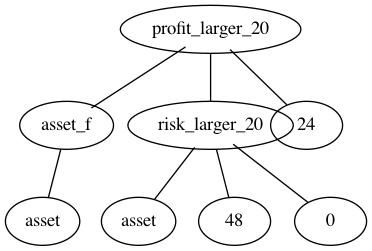

In [12]:
pop = toolbox.population(n=10)
hof = tools.HallOfFame(1)

mstats = stats()

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.3, mutpb=0.2, ngen=25, halloffame=hof, stats=mstats, verbose=True)


plot(hof)

# Display the tree
from IPython.display import Image
Image(filename="tree0.png")